## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
from collections import Counter
from nltk.stem import SnowballStemmer 

In [2]:
data = pd.read_csv('data.csv')
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Вывод

Рассмотрим полученную информацию.

Всего в таблице 12 столбцов с разными типами данных: два столбца с данными с плавающей точкой, пять - с целочисленными типами данных, пять - с типом данных строка.

Количество значений в столбцах различается. Это говорит о том, что в данных есть нулевые значения. 

Подробно разберём, какие в *data* столбцы и какую информацию они содержат:

* children — количество детей в семье;
* days_employed — общий трудовой стаж в днях;
* dob_years — возраст клиента в годах;
* education — уровень образования клиента;
* education_id — идентификатор уровня образования;
* family_status — семейное положение;
* family_status_id — идентификатор семейного положения;
* gender — пол клиента;
* income_type — тип занятости;
* debt — имел ли задолженность по возврату кредитов;
* total_income — ежемесячный доход;
* purpose — цель получения кредита.

По первыми десяти строкам данных также видно, что в столбце *days_employed* присутствуют отрицательные значения, а в столбце *education* у данных разный регистр, что тоже доставит проблем при анализе. Также столбец *days_employed*, в котором содержится трудовой стаж заёмщика в дня содержит дробные числа, да ещё и отрицательные, хотя должно быть целое число.


### Шаг 2. Предобработка данных

### Обработка пропусков

Проверим данные на наличие пропусков вызовом набора методов для суммирования пропущенных значений.

In [4]:
data.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Мы видим что пропуски присутствуют в двух столбцах и их количество одинаково, вероятно это не случайно. 2174 пропуска - это около 10% от общего количества данных, мы не можем их потерять, иначе это отразится на точности нашего исследования.

Выведем первые десять строк выбрав по столбцу *total_income* пропущенные значения.

In [5]:
data[data['total_income'].isnull()].head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


Мы видим, что отсутствие данных по двум столбцам встречается одновременно в одной строке. Скорее всего это случайная ошибка.

Также мы видим, что пропуски нельзя заменить на среднее или медианное значение, поскольку стаж работы, как правило, зависит от возраста, а ежемесячный доход - от стажа, образования и других факторов. 

Для начала избавимся от минусов вначале некоторых строк в столбце *days_employed*, используя функцию *abs()*, которая возвращает модуль числа.

In [6]:
data['days_employed'] = data['days_employed'].abs()

Теперь мы проверим как меняется среднее значение количества дней стажа в зависимости от возраста, используем группировку по столбцу *dob_years* и метод *agg()*.

In [7]:
data.groupby('dob_years')['days_employed'].agg(['count','mean'])

,count,mean
dob_years,,
0,91,69516.105102
19,13,633.678086
20,46,684.944308
21,93,709.440930
22,166,2793.321854
23,218,827.309437
24,243,1026.405485
25,334,1088.406453
26,373,3214.617245


Мы видим, что с увеличением возраста увеличивается и количество дней стажа. Поэтому для заполнения пропусков нам нужно разбить заёмщиков на группы по возрасту с шагом в десять лет, высчитать для каждой среднее число дней стажа и исправить наши данные.

Также мы видим артефакт в переданных нам данных. Выделяются заёмщики с возрастом 0. Вряд ли 91 младенец со средним трудовым стажем в 70 тысяч дней обратился в банк за кредитом. Таких данных у нас менее 0.5%, поэтому мы можем избавиться от них без потери качества исследования.

In [8]:
data = data[data['dob_years'] != 0]

Пропишем функцию, которая в зависимости от возраста клиента возвращала бы возрастную группу: *'30 лет и младше', 'от 31 до 40 лет', 'от 41 до 50 лет', 'от 51 до 60 лет', 'старше 60 лет'*. Затем добавим эти данные к нашей таблице в новый столбец *age_group*.

In [9]:
def age_group(age):
    if age <= 30:
        return '30 лет и младше'
    if 30 < age <= 40:
        return 'от 31 до 40 лет'
    if 40 < age <= 50:
        return 'от 41 до 50 лет'
    if 50 < age <= 60:
        return 'от 51 до 60 лет'
    return 'старше 60 лет'

data['age_group'] = data['dob_years'].apply(age_group)
data.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,от 41 до 50 лет
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,от 31 до 40 лет
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,от 31 до 40 лет
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,от 31 до 40 лет
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,от 51 до 60 лет
5,0,926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,30 лет и младше
6,0,2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,от 41 до 50 лет
7,0,152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,от 41 до 50 лет
8,2,6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,от 31 до 40 лет
9,0,2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,от 41 до 50 лет


Знакомым нам уже методом группировки выведем сводную таблицу, отражающую среднюю величину трудового стажа в днях по возрастным группам.

In [10]:
mean_days_employed = data.groupby('age_group')['days_employed'].agg(['mean'])
mean_days_employed

,mean
age_group,
30 лет и младше,2027.154893
от 31 до 40 лет,4691.122800
от 41 до 50 лет,16701.293627
от 51 до 60 лет,153165.111212
старше 60 лет,290708.554837


Теперь мы можем заполнить недостающие значения в столбце *days_employed*. Для начала присвоим пропущенным данным значение 0, а затем, отыскав по условию нужные строчки, присвоим им значение *mean* из таблицы *mean_days_employed*.

In [11]:
data['days_employed'] = data['days_employed'].fillna(0)

In [12]:
def mean_days(age_group):
    if age_group == '30 лет и младше':
        return mean_days_employed['mean'][0]
    if age_group == 'от 31 до 40 лет':
        return mean_days_employed['mean'][1]
    if age_group == 'от 41 до 50 лет':
        return mean_days_employed['mean'][2]
    if age_group == 'от 51 до 60 лет':
        return mean_days_employed['mean'][3]
    if age_group == 'старше 60 лет':
        return mean_days_employed['mean'][4]

data.loc[data['days_employed'] == 0, 'days_employed'] = data['age_group'].apply(mean_days)
data.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,от 41 до 50 лет
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,от 31 до 40 лет
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,от 31 до 40 лет
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,от 31 до 40 лет
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,от 51 до 60 лет
5,0,926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,30 лет и младше
6,0,2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,от 41 до 50 лет
7,0,152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,от 41 до 50 лет
8,2,6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,от 31 до 40 лет
9,0,2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,от 41 до 50 лет


Как мы видим, пустых строчек в столбце *days_employed* не осталось. Теперь разберёмся с пропусками в столбце с ежемесячным доходом. Проверим, как соотносится ежемесячный доход клиента с его типом занятости, стажем работы (для удобства возьмём возрастные группы) и образованием. 

In [13]:
data.groupby('income_type')['total_income'].agg(['count','mean', 'median'])

,count,mean,median
income_type,,,
безработный,2,131339.751676,131339.751676
в декрете,1,53829.130729,53829.130729
госслужащий,1306,171008.225815,150521.917580
компаньон,4559,202483.482019,172280.581712
пенсионер,3426,137120.690001,118557.179415
предприниматель,1,499163.144947,499163.144947
сотрудник,9964,161404.247418,142594.396847
студент,1,98201.625314,98201.625314


In [14]:
data.groupby('age_group')['total_income'].agg(['count','mean', 'median'])

,count,mean,median
age_group,,,
30 лет и младше,3366,161360.467702,143482.406904
от 31 до 40 лет,5170,177354.594640,155157.414803
от 41 до 50 лет,4754,177438.794269,153562.300598
от 51 до 60 лет,4053,159267.851798,137854.819127
старше 60 лет,1917,144111.109129,122731.599800


In [15]:
data.groupby('education')['total_income'].agg(['count','mean', 'median'])

,count,mean,median
education,,,
ВЫСШЕЕ,250,199986.563897,167206.162054
Высшее,242,215035.923783,180186.682659
НАЧАЛЬНОЕ,16,153573.262494,129666.892242
НЕОКОНЧЕННОЕ ВЫСШЕЕ,22,176496.585093,163911.559034
Начальное,14,110757.228534,104570.429306
Неоконченное высшее,40,159188.363670,160402.480835
СРЕДНЕЕ,703,151269.983491,133814.426277
Среднее,643,153976.652438,135293.829632
УЧЕНАЯ СТЕПЕНЬ,1,198570.757322,198570.757322


Как видно из таблиц и тип занятости, и стаж влияют на различия в среднем ежемесячном доходе, а уровень образования не всегда влияет на заработок человека, хотя и прослеживается определённая корреляция. К тому же, видно, что в столбце с образованием много дибликатов, от которых ещё предстоит избавиться. Из методов определения усреднённого значания для заполнения наших пропусков воспользуемся медианным значением, как более подходящим для нашего вопроса. Составим сводную таблицу *data_pivot* используя метод *pivot_table()*, где в качестве индекса возьмем столбец *income_type* по колонке *age_group*, а в качестве значений - медианное значение по *total_income*.

In [16]:
data_pivot = data.pivot_table(index=['income_type'], columns='age_group', values='total_income', aggfunc='median')
data_pivot

age_group,30 лет и младше,от 31 до 40 лет,от 41 до 50 лет,от 51 до 60 лет,старше 60 лет
income_type,,,,,
безработный,NaN,59956.991984,202722.511368,NaN,NaN
в декрете,NaN,53829.130729,NaN,NaN,NaN
госслужащий,145017.937533,156345.493872,149045.531406,146204.734300,153899.233202
компаньон,160715.180925,181059.871123,177202.579089,170928.667481,182324.934270
пенсионер,80044.196101,115469.381690,142125.429143,120367.978195,115080.782380
предприниматель,499163.144947,NaN,NaN,NaN,NaN
сотрудник,135737.638845,145390.317641,143450.248617,141852.298615,147190.698952
студент,98201.625314,NaN,NaN,NaN,NaN


In [17]:
data_pivot['30 лет и младше'][2]

145017.93753253992

Посмотрим, сколько строк с пустыми значениями по каждому типу занятости.

In [18]:
data_income_null = data[data['total_income'].isnull()]
data_income_null['income_type'].value_counts()

сотрудник          1100
компаньон           506
пенсионер           410
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Теперь для удобства сначала заменим все пропущенные значения в столбце *total_income* на 0, а затем присвоим им соответствующие значения из таблицы *data_pivot*. После вызовем метод *value_counts()* и выведем первые 20 значений, чтобы убедиться, что нулей не осталось.

In [19]:
data['total_income'] = data['total_income'].fillna(0)

In [20]:
data.loc[(data['age_group'] == '30 лет и младше') & (data['total_income'] == 0) 
         & (data['income_type'] == 'госслужащий'), 'total_income'] = data_pivot['30 лет и младше'][2]
data.loc[(data['age_group'] == 'от 31 до 40 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'госслужащий'), 'total_income'] = data_pivot['от 31 до 40 лет'][2]
data.loc[(data['age_group'] == 'от 41 до 50 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'госслужащий'), 'total_income'] = data_pivot['от 41 до 50 лет'][2]
data.loc[(data['age_group'] == 'от 51 до 60 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'госслужащий'), 'total_income'] = data_pivot['от 51 до 60 лет'][2]
data.loc[(data['age_group'] == 'старше 60 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'госслужащий'), 'total_income'] = data_pivot['старше 60 лет'][2]
data.loc[(data['age_group'] == '30 лет и младше') & (data['total_income'] == 0) 
         & (data['income_type'] == 'компаньон'), 'total_income'] = data_pivot['30 лет и младше'][3]
data.loc[(data['age_group'] == 'от 31 до 40 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'компаньон'), 'total_income'] = data_pivot['от 31 до 40 лет'][3]
data.loc[(data['age_group'] == 'от 41 до 50 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'компаньон'), 'total_income'] = data_pivot['от 41 до 50 лет'][3]
data.loc[(data['age_group'] == 'от 51 до 60 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'компаньон'), 'total_income'] = data_pivot['от 51 до 60 лет'][3]
data.loc[(data['age_group'] == 'старше 60 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'компаньон'), 'total_income'] = data_pivot['старше 60 лет'][3]
data.loc[(data['age_group'] == '30 лет и младше') & (data['total_income'] == 0) 
         & (data['income_type'] == 'пенсионер'), 'total_income'] = data_pivot['30 лет и младше'][4]
data.loc[(data['age_group'] == 'от 31 до 40 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'пенсионер'), 'total_income'] = data_pivot['от 31 до 40 лет'][4]
data.loc[(data['age_group'] == 'от 41 до 50 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'пенсионер'), 'total_income'] = data_pivot['от 41 до 50 лет'][4]
data.loc[(data['age_group'] == 'от 51 до 60 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'пенсионер'), 'total_income'] = data_pivot['от 51 до 60 лет'][4]
data.loc[(data['age_group'] == 'старше 60 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'пенсионер'), 'total_income'] = data_pivot['старше 60 лет'][4]
data.loc[(data['age_group'] == '30 лет и младше') & (data['total_income'] == 0) 
         & (data['income_type'] == 'сотрудник'), 'total_income'] = data_pivot['30 лет и младше'][6]
data.loc[(data['age_group'] == 'от 31 до 40 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'сотрудник'), 'total_income'] = data_pivot['от 31 до 40 лет'][6]
data.loc[(data['age_group'] == 'от 41 до 50 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'сотрудник'), 'total_income'] = data_pivot['от 41 до 50 лет'][6]
data.loc[(data['age_group'] == 'от 51 до 60 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'сотрудник'), 'total_income'] = data_pivot['от 51 до 60 лет'][6]
data.loc[(data['age_group'] == 'старше 60 лет') & (data['total_income'] == 0) 
         & (data['income_type'] == 'сотрудник'), 'total_income'] = data_pivot['старше 60 лет'][6]
data.loc[(data['total_income'] == 0) 
         & (data['income_type'] == 'предприниматель'), 'total_income'] = data_pivot['30 лет и младше'][5]

data['total_income'].value_counts().head(20)

143450.248617    340
145390.317641    330
135737.638845    239
120367.978195    213
181059.871123    185
115080.782380    173
141852.298615    156
177202.579089    129
170928.667481     95
160715.180925     93
156345.493872     54
147190.698952     39
149045.531406     36
145017.937533     27
146204.734300     27
142125.429143     20
182324.934270      9
115469.381690      6
153899.233202      5
499163.144947      2
Name: total_income, dtype: int64

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21424 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21424 non-null  int64  
 1   days_employed     21424 non-null  float64
 2   dob_years         21424 non-null  int64  
 3   education         21424 non-null  object 
 4   education_id      21424 non-null  int64  
 5   family_status     21424 non-null  object 
 6   family_status_id  21424 non-null  int64  
 7   gender            21424 non-null  object 
 8   income_type       21424 non-null  object 
 9   debt              21424 non-null  int64  
 10  total_income      21424 non-null  float64
 11  purpose           21424 non-null  object 
 12  age_group         21424 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.9+ MB


Пустых значений в наших данных больше не осталось.

### Вывод

Итак, мы полностью избавились от пропущенных значений в столбцах со стажем и ежемесячным доходом с минимальными потерями и заменили их усреднёнными значениями. Поскольку пропуски были в одних и тех же строках, то скорее всего это случайная ошибка. Либо при выгрузке данных в один файл потерялись данные, либо какой-то сотрудник просто забыл их добавить.

### Замена типа данных

Избавившись от пропусков в данных, продолжим приводить наши данные в порядок. В нашей таблице столбец *days_emploeyd*, отвечающий за трудовой стаж в днях, имеет тип *float* и выдаёт десятичные значения. Но количество дней не может быть дробным. поэтому приведём эти данные к целочисленным значениям. Используем метод *astype* и укажем тип данных *int*.

In [22]:
data['days_employed'] = data['days_employed'].astype('int')

In [23]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,от 41 до 50 лет
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,от 31 до 40 лет
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,от 31 до 40 лет
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,от 31 до 40 лет
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,от 51 до 60 лет


### Вывод

Мы исправили очередную неточность в данных, изменив тип данных столбца со стажем работы в днях и столбца *debt*. В остальных столбцах тип данных соответствует тому, что там представлено.

### Обработка дубликатов

Теперь проверим, нет ли в наших данных дубликатов, которые могут повлиять на наше исследование и исказить данные. Вызовем метод поиска дубливатов *duplicated()* и просуммируем результат. 

In [24]:
data.duplicated().sum()

54

In [25]:
data.shape

(21424, 13)

Мы нашли 54 дубликата в наших данных. избавимся от них вызвав метод *drop_duplicates()*.

In [26]:
data = data.drop_duplicates().reset_index(drop = True)
data.shape

(21370, 13)

Количество строчек в наших данных ещё уменьшилось. Проверим по столбцам какие уникальные данные в них содержатся, применив к столбцам метод *unique()*. В данных о количестве детей не может быть дубликатов, но мы на всякий случай проверим какие уникальные значения там есть.

In [27]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

Неожиданно тут мы встретили отрицательное значение, а также странную цифру 20. У кого-то есть 20 детей в семье! Исправим отрицательное значение с помощью *abs()* и проверим сколько же таких многодетных клиентов клиентов. Для этого вызовем метод *value_counts*.

In [28]:
data['children'] = data['children'].abs()
data['children'].value_counts()

0     14038
1      4840
2      2039
3       328
20       75
4        41
5         9
Name: children, dtype: int64

У 75 клиентов банка по 20 детей! Учитывая, что следующая по количеству детей группа это 5, то такая цифра выглядит как артефакт. Чтобы не портить результат наших исследований, удалим эти строчки.

In [29]:
data = data[data['children'] != 20]
data['children'].value_counts()

0    14038
1     4840
2     2039
3      328
4       41
5        9
Name: children, dtype: int64

Исправив данные в столбце *children*, перейдём к остальным столбцам.

In [30]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

В данных с уровнем образования клиента явно есть дубликаты, вызванные тем, что данные различаются по регистру. Исправим этот недочёт. Приведём строчки в столбце к нижнему регистру методом *str.low()* и снова выведем на экран уникальные значения по столбцу.

In [31]:
data['education'] = data['education'].str.lower()

In [32]:
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Тепрь у нас в данных всего 5 типов уровня образования: начальное, среднее, высшее, неоконченное высшее и учёная степень. Продолжим искать дубликаты.

In [33]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

В столбце *family_status* мы не нашли дубликатов, только пять категорий.

In [34]:
data['purpose'].value_counts()

свадьба                                   787
на проведение свадьбы                     765
сыграть свадьбу                           760
операции с недвижимостью                  671
покупка коммерческой недвижимости         656
покупка жилья для сдачи                   649
операции с коммерческой недвижимостью     644
операции с жильем                         642
покупка жилья                             637
покупка жилья для семьи                   636
жилье                                     636
недвижимость                              628
строительство собственной недвижимости    627
операции со своей недвижимостью           626
строительство жилой недвижимости          621
покупка своего жилья                      619
строительство недвижимости                619
покупка недвижимости                      616
ремонт жилью                              603
покупка жилой недвижимости                601
на покупку своего автомобиля              502
заняться высшим образованием      

В столбце с целью получения кредита обнаружилось много строк с разными данными, которые по сути являются дубликатами, но простыми методами от них не избавиться. Здесь нам поможет лемматизация. 

### Вывод

Мы избавились от дубликатов и прочих артефактов в наших данных во всех столбцах кроме *purpose*. В этом столбце одни и те же цели записаны по-разному. В целом их можно свести к нескольким категориям для удобства.

### Лемматизация

Импортируем библиотеку *pymystem3*, которая поможет нам решить проблему с определением категорий.

In [35]:
pip install pymystem3

Note: you may need to restart the kernel to use updated packages.


In [36]:
from pymystem3 import Mystem
m = Mystem()

Выберем все уникальные значения в столбце с целями кредита и сохраним их в отдельную переменную *data_purpose*.

In [37]:
data_purpose = data['purpose'].unique()
data_purpose

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Соберём в одну строчку все наши уникальные значения, чтобы потом можно было подсчитать количество упоминаний слов в *purpose*.

In [38]:
data_lemmas = ''
for i in data_purpose:
    data_lemmas += (i + ' ')
data_lemmas

'покупка жилья приобретение автомобиля дополнительное образование сыграть свадьбу операции с жильем образование на проведение свадьбы покупка жилья для семьи покупка недвижимости покупка коммерческой недвижимости покупка жилой недвижимости строительство собственной недвижимости недвижимость строительство недвижимости на покупку подержанного автомобиля на покупку своего автомобиля операции с коммерческой недвижимостью строительство жилой недвижимости жилье операции со своей недвижимостью автомобили заняться образованием сделка с подержанным автомобилем получение образования автомобиль свадьба получение дополнительного образования покупка своего жилья операции с недвижимостью получение высшего образования свой автомобиль сделка с автомобилем профильное образование высшее образование покупка жилья для сдачи на покупку автомобиля ремонт жилью заняться высшим образованием '

In [39]:
lemmas = m.lemmatize(data_lemmas)

Counter(data_purpose)

Counter({'покупка жилья': 1,
         'приобретение автомобиля': 1,
         'дополнительное образование': 1,
         'сыграть свадьбу': 1,
         'операции с жильем': 1,
         'образование': 1,
         'на проведение свадьбы': 1,
         'покупка жилья для семьи': 1,
         'покупка недвижимости': 1,
         'покупка коммерческой недвижимости': 1,
         'покупка жилой недвижимости': 1,
         'строительство собственной недвижимости': 1,
         'недвижимость': 1,
         'строительство недвижимости': 1,
         'на покупку подержанного автомобиля': 1,
         'на покупку своего автомобиля': 1,
         'операции с коммерческой недвижимостью': 1,
         'строительство жилой недвижимости': 1,
         'жилье': 1,
         'операции со своей недвижимостью': 1,
         'автомобили': 1,
         'заняться образованием': 1,
         'сделка с подержанным автомобилем': 1,
         'получение образования': 1,
         'автомобиль': 1,
         'свадьба': 1,
         'по

### Вывод

Не смотря на то, что цели были записаны в разных формулировках, мы видим, что в основном люди берут кредит на покупку чего-либо. В нашем случае это недвижимость и автомобили. Также некоторые занимают у банка на свадьбу и образование, а кто-то захотел сделать ремонт.

### Категоризация данных

Для удобства нашего анализа приведём все цели к нескольким категориям. Мы будем использовать для этого стемминг. Пройдёмся по данным *data_purpose* и определим основу ключевых слов, по которым мы потом будем выбирать наши данные и группировать.

In [40]:

russian_stemmer = SnowballStemmer('russian')

for word in data_purpose:
    print ('Исходное слово - ' + word + ', после стемминга - ' + russian_stemmer.stem(word))

Исходное слово - покупка жилья, после стемминга - покупка жил
Исходное слово - приобретение автомобиля, после стемминга - приобретение автомобил
Исходное слово - дополнительное образование, после стемминга - дополнительное образован
Исходное слово - сыграть свадьбу, после стемминга - сыграть свадьб
Исходное слово - операции с жильем, после стемминга - операции с жил
Исходное слово - образование, после стемминга - образован
Исходное слово - на проведение свадьбы, после стемминга - на проведение свадьб
Исходное слово - покупка жилья для семьи, после стемминга - покупка жилья для сем
Исходное слово - покупка недвижимости, после стемминга - покупка недвижим
Исходное слово - покупка коммерческой недвижимости, после стемминга - покупка коммерческой недвижим
Исходное слово - покупка жилой недвижимости, после стемминга - покупка жилой недвижим
Исходное слово - строительство собственной недвижимости, после стемминга - строительство собственной недвижим
Исходное слово - недвижимость, после стемм

Итак, мы выяснили основу слов, по которым мы будем группировать: *автомобил* для категории *автомобиль*, *жил* и *недвижим* для категории *недвижимость* и *свадьб* для категории *свадьба*. Тепрь напишем функцию, которая добавит к нашей исходной таблице ещё один столбец *purpose_group*, где будем хранить категории целей кредита.

In [41]:
def purpose_group(row):
    for word in row.split(' '):
        stemmed_word = russian_stemmer.stem(word)
        if stemmed_word == 'автомобил':
            return 'автомобиль'
        if stemmed_word == 'жил' or stemmed_word == 'недвижим':
            return 'недвижимость'
        if stemmed_word == 'образован':
            return 'образование'
        if stemmed_word ==  'свадьб':
            return 'свадьба'

data['purpose_group'] = data['purpose'].apply(purpose_group)
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,purpose_group
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,от 41 до 50 лет,недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,от 31 до 40 лет,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,от 31 до 40 лет,недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,от 31 до 40 лет,образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,от 51 до 60 лет,свадьба
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,30 лет и младше,недвижимость
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,от 41 до 50 лет,недвижимость
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,от 41 до 50 лет,образование
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,от 31 до 40 лет,свадьба
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,от 41 до 50 лет,недвижимость


In [42]:
data['purpose_group'].value_counts()

недвижимость    10731
образование      3981
автомобиль       3796
свадьба          2312
Name: purpose_group, dtype: int64

### Вывод

Как мы можем судить по основным категориям, то больше половины из всех случаев займа это кредит на недвижимость. Примерно в равной степени берут кредиты на образование и покупку автомобиля, и реже - на свадебные торжества.

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Поскольку в столбце *debt* у нас всего два значения, подсчитаем для начала среднее значение по столбцу, которое будет отражать долю должников.

In [43]:
data['debt'].mean()

0.0810049307349143

Доля должников в целом небольшая 0.08 или 8% от числа всех заёмщиков. А теперь возьмём сводную таблицу и посмотрим, как количество детей влияет на возврат кредита в срок.

In [44]:
data.groupby('children')['debt'].agg(['mean', 'count'])

,mean,count
children,,
0,0.075367,14038
1,0.091322,4840
2,0.095145,2039
3,0.082317,328
4,0.097561,41
5,0.000000,9


Как мы видим, доля должников по количеству детей не сильно меняется и варьируется в пределах двух процентов. Посмотрим наглядно на графике. 

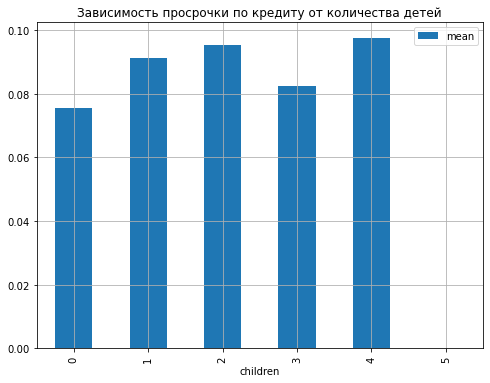

In [45]:
data.groupby('children')['debt'].agg(['mean']).plot(kind='bar', 
                                                    grid=True, figsize=(8,6), 
                                                    title='Зависимость просрочки по кредиту от количества детей');

### Вывод

В целом количество детей не сильно влияет возврат кредита в срок. Чуть меньше должников с реди тех, у кого один ребёнок, чуть больше - у кого четверо детей. То, что люди с пятью детьми вовсе не являются должниками, не говорит, что они всегда выплачивают кредиты в срок. В нашей выборке всего 9 таких случаев, этого не достаточно, чтобы делать какие-то выводы.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [46]:
data.groupby('family_status')['debt'].agg(['mean', 'count'])

,mean,count
family_status,,
Не женат / не замужем,0.097666,2785
в разводе,0.071006,1183
вдовец / вдова,0.065263,950
гражданский брак,0.092736,4130
женат / замужем,0.075447,12247


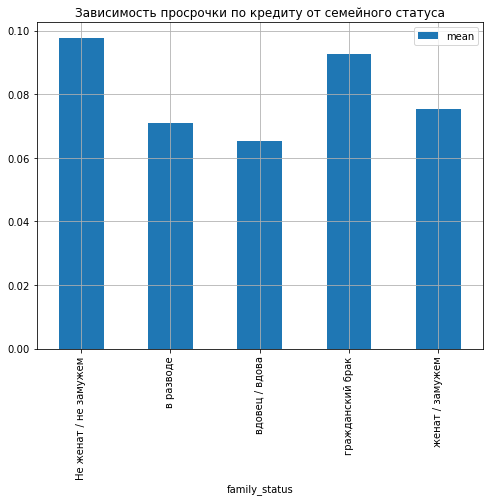

In [47]:
data.groupby('family_status')['debt'].agg(['mean']).plot(kind='bar', 
                                                         grid=True, figsize=(8,6), 
                                                         title='Зависимость просрочки по кредиту от семейного статуса');

### Вывод

Смотря на зависимость между семейным положением мы можем сказать, что люди не вступавшие в брак чаще являются должниками по кредиту, чем те, кто прошёл через ЗАГС. Видимо ответственный поступок создания семьи заставляет ответственнее подходить ко всему, в том числе  и к возврату кредита. Меньше всего должников среди вдов и вдовцов.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [48]:
data.groupby('total_income')['debt'].agg(['mean', 'count'])

,mean,count
total_income,,
2.066726e+04,1.0,1
2.120528e+04,0.0,1
2.136765e+04,0.0,1
2.169510e+04,0.0,1
2.189561e+04,0.0,1
...,...,...
1.711309e+06,0.0,1
1.715018e+06,0.0,1
1.726276e+06,0.0,1


В таком виде данные не репрезентативны, разобъём их на равные группы. Для этого используем метод *pd.cut()*, чтобы получить пять групп.

In [49]:
data['total_income_group'] = pd.cut(data['total_income'],5)

In [50]:
data.groupby('total_income_group')['debt'].agg(['mean', 'count'])

,mean,count
total_income_group,,
"(18422.327, 469654.617]",0.081350,21008
"(469654.617, 918641.97]",0.054264,258
"(918641.97, 1367629.323]",0.047619,21
"(1367629.323, 1816616.676]",0.000000,6
"(1816616.676, 2265604.029]",0.500000,2


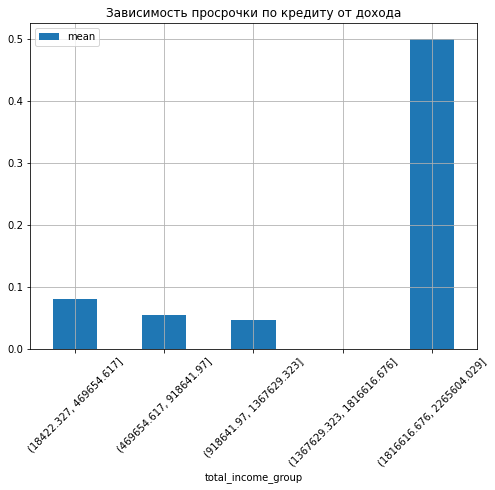

In [51]:
data.groupby('total_income_group')['debt'].agg(['mean']).plot(kind='bar', 
                                                              grid=True, figsize=(8,6), rot=45,
                                                              title='Зависимость просрочки по кредиту от дохода');

### Вывод

При сопоставлении данных ежемесячного дохода и возврата кредита мы видим, что чем больше доход человека, тем реже он становится должником. Исключение составляет группа, доход которой около двух миллионов в месяц, в ней один из двух заёмщиков имел задолженность по возврату, чем испортил статистику.

- Как разные цели кредита влияют на его возврат в срок?

In [52]:
data.groupby('purpose_group')['debt'].agg(['mean', 'count'])

,mean,count
purpose_group,,
автомобиль,0.093256,3796
недвижимость,0.072407,10731
образование,0.092690,3981
свадьба,0.078287,2312


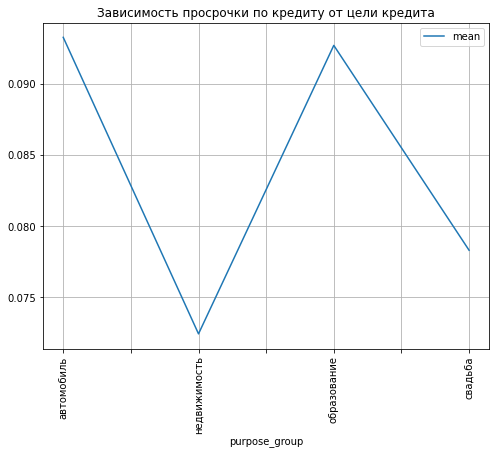

In [53]:
data.groupby('purpose_group')['debt'].agg(['mean']).plot(grid=True, figsize=(8,6), rot=90, 
                                                         title='Зависимость просрочки по кредиту от цели кредита');

### Вывод

Сравнив данные по тому, был ли кредитор должником и на какую цель занимал у банка, мы можем прийти к выводу, что охотнее возвращают в срок те, кто собирался сыграть свадьбу или купить недвижимость. Те же, кто занимал на образование или покупку автомобиля становились должниками чаще.

### Шаг 4. Общий вывод

Подводя итог нашему исследованию мы можем сказать, что:
* количество детей не влияет на возврат кредита в срок, но есть небольшая тенденция на увеличение вероятности просрочки по кредиту с увеличением количества детей;
* люди не вступавшие в брак, чаще становятся должниками, чем те, кто состоит или состоял в браке;
* чем больше ежемесячный доход заёмщика, тем больше вероятность, что он заплатит по кредиту в срок;
* люди занимающие у банка на покупку автомобиля или на образование реже соблюдают сроки по платежу, чем те, кто покупает недвижимость или организует свадьбу.
В целом процент должников по какой-либо выборке не превышает 10%. Самым добросовестным заёмщиком будет вдова или вдовец без детей с высоким уровнем дохода (от 1 миллиона рублей), собирающися приобрести жильё. А большая вероятность стать должником у не женатого(не замужнего) человека с четырьмя детьми и небольшим ежемесячным доходом, который хочет купить автомобиль.